In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

## Математическая справка

Мы решаем уравнение Пуассона:

$$
u_{xx} + u_{yy} = f(x, y)
$$

в прямоугольной области:
$$
0 < x < \pi,\quad -1 < y < 1.
$$

$$
f(x,y) = 4 - 29 \sin(2x + 5y)
$$

То есть за распределение отвечает синусоидальный источник.

---

## 2. Граничные условия

### Периодичность по оси x:
$$
u(x+\pi, y)=u(x,y)
$$

То есть левый край и правый край должны «стыковаться».  

Это означает, что в матрице системы узлы при \(x=0\) и \(x=\pi\) будут связаны между собой.

---

### Дирихле по y:

$$
u(x,-1) = 2+\sin(2x-5)
$$
$$
u(x,1) = 2+\sin(2x+5)
$$


---

## 3. Как мы дискретизируем?

Берём сетку:

$$
x_i = x_0 + i h_x,\quad i=0,\dots,N_x
$$
$$
y_j = y_0 + j h_y,\quad j=0,\dots,N_y
$$

Приближаем вторые производные:

$$
u_{xx} \approx \frac{u_{i-1,j} - 2u_{i,j} + u_{i+1,j}}{h_x^2}
$$
$$
u_{yy} \approx \frac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{h_y^2}
$$

---

## 4. Матричная система

Для каждого внутреннего узла получается:

$$
-2\left(\frac{1}{h_x^2}+\frac{1}{h_y^2}\right) u_{i,j}
+ \frac{1}{h_x^2}(u_{i-1,j} + u_{i+1,j})
+ \frac{1}{h_y^2}(u_{i,j-1} + u_{i,j+1})
 = f(x_i,y_j)
$$

✳ В итоге мы сформируем **разреженную матрицу A** и правую часть **b**, после чего решим:

$$
A\,u = b
$$

---

## 5. Точное решение для проверки

Нам дано точное решение:

$$
u_0(x,y)=\sin(2x+5y)+2y^2
$$

Мы сравним численное решение с ним и построим графики.

---


In [74]:
# Параметры области
x0, x1 = 0, np.pi
y0, y1 = -1, 1 

# Правая часть уравнения и точное решение
def f_source(x, y):
    return 4 - 29 * np.sin(2 * x + 5 * y)

def exact_solution(x, y):
    return np.sin(2 * x + 5 * y) + 2 * y**2


In [75]:
def generate_grid(Nx, Ny):
    """
    Создание сетки, шагов и матриц X,Y.
    """
    hx = (x1 - x0) / Nx
    hy = (y1 - y0) / Ny

    x = np.linspace(x0, x1, Nx + 1)
    y = np.linspace(y0, y1, Ny + 1)

    X, Y = np.meshgrid(x, y, indexing='ij')
    return x, y, X, Y, hx, hy


In [76]:
def idx(i, j, Ny):
    """
    Преобразует (i,j) в 1D индекс.
    """
    return i * (Ny + 1) + j

def build_system(Nx, Ny, x, y, hx, hy):
    """
    Формирует разреженную матрицу A и RHS вектор b для задачи (а).
    """
    N = (Nx + 1) * (Ny + 1)
    A = lil_matrix((N, N))
    b = np.zeros(N)

    cx = 1 / hx**2
    cy = 1 / hy**2

    for i in range(Nx + 1):
        for j in range(Ny + 1):

            k = idx(i, j, Ny)

            # ==== ГРАНИЦЫ ПО y (Дирихле) ====
            if j == 0:
                A[k, k] = 1
                b[k] = 2 + np.sin(2 * x[i] - 5)
                continue

            if j == Ny:
                A[k, k] = 1
                b[k] = 2 + np.sin(2 * x[i] + 5)
                continue

            # ==== ВНУТРЕННИЙ УЗЕЛ ====
            A[k, k] = -2*(cx + cy)

            # периодичность по x
            i_left  = (i - 1) % (Nx)
            i_right = (i + 1) % (Nx)

            A[k, idx(i_left, j, Ny)] += cx
            A[k, idx(i_right, j, Ny)] += cx

            A[k, idx(i, j - 1, Ny)] += cy
            A[k, idx(i, j + 1, Ny)] += cy

            b[k] = f_source(x[i], y[j])

    return csr_matrix(A), b


In [77]:
def solve_poisson(Nx, Ny):
    """
    Полный цикл решения:
    1) создаёт сетку
    2) формирует A и b
    3) решает систему
    4) возвращает X,Y, решение и точное решение
    """
    x, y, X, Y, hx, hy = generate_grid(Nx, Ny)
    A, b = build_system(Nx, Ny, x, y, hx, hy)
    u_vec = spsolve(A, b)
    u_num = u_vec.reshape((Nx + 1, Ny + 1))
    u_ex = exact_solution(X, Y)
    return X, Y, u_num, u_ex


In [78]:
def compute_error(u_num, u_ex):
    err = np.abs(u_num - u_ex)
    return np.max(err), np.mean(err)
def plot_solution(X, Y, u_num, u_ex):
    error = np.abs(u_num - u_ex)

    fig = plt.figure(figsize=(16, 4))

    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, u_num, cmap='viridis')
    ax1.set_title("Численное решение")

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, u_ex, cmap='viridis')
    ax2.set_title("Точное решение")

    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X, Y, error, cmap='inferno')
    ax3.set_title("Ошибка")

    plt.show()


In [79]:
def vis_sol():
    Nx = 40
    Ny = 40

    X, Y, u_num, u_ex = solve_poisson(Nx, Ny)
    max_err, mean_err = compute_error(u_num, u_ex)

    print("Nx =", Nx, "Ny =", Ny)
    print("Максимальная ошибка:", max_err)
    print("Средняя ошибка:", mean_err)

    plot_solution(X, Y, u_num, u_ex)


In [80]:
def convergence_test(grid_sizes):
    errors = []

    for N in grid_sizes:
        X, Y, u_num, u_ex = solve_poisson(N, N)
        max_err, mean_err = compute_error(u_num, u_ex)
        errors.append((N, mean_err))
        print(f"N = {N:4d}   mean error = {mean_err:.6e}")

    return errors

def compute_orders(errors):
    """
    errors — список вида [(N, err), ...]
    Возвращает список порядков аппроксимации между соседними сетками.
    """
    orders = []
    for (N1, e1), (N2, e2) in zip(errors[:-1], errors[1:]):
        h_ratio = N2 / N1             # потому что h = 1/N
        order = np.log(e1 / e2) / np.log(h_ratio)
        orders.append(order)
    return orders


Nx = 40 Ny = 40
Максимальная ошибка: 0.006184694710493377
Средняя ошибка: 0.002944952074240045


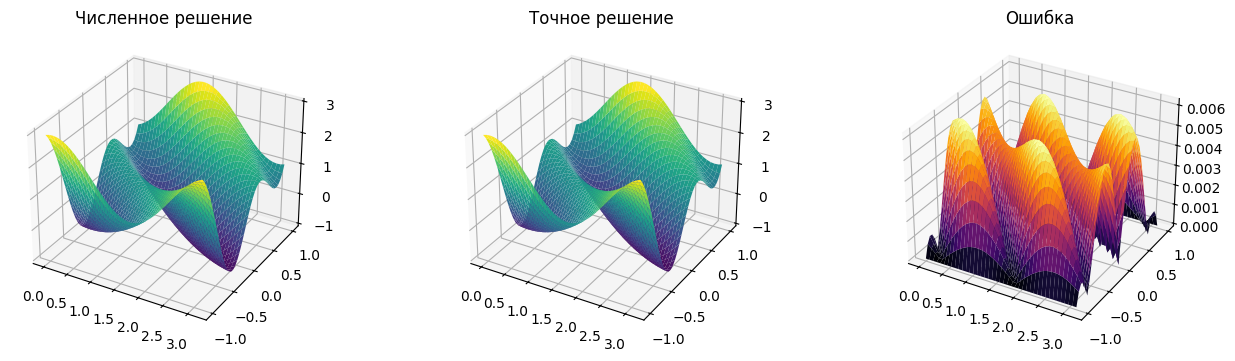

N =   20   mean error = 1.155648e-02
N =   40   mean error = 2.944952e-03
N =   80   mean error = 7.454791e-04

Порядок аппроксимации между сетками:
20 -> 40 : p = 1.972385
40 -> 80 : p = 1.982004


In [81]:
def main():
    vis_sol()
    grid_sizes = [20, 40, 80]
    errors = convergence_test(grid_sizes)
    orders = compute_orders(errors)

    print("\nПорядок аппроксимации между сетками:")
    for i, p in enumerate(orders, start=1):
        print(f"{grid_sizes[i-1]} -> {grid_sizes[i]} : p = {p:.6f}")

main()

## Пункт (b). Бесконечная пластина с точечными источниками тепла

**Физика задачи**

Есть бесконечная в плоскости пластина, но конечной толщины:
по вертикали \( y $\in$ [0, H] \).

Внутри пластины расположено много точечных источников тепла
с постоянной мощностью (их можно считать нагревателями).

Пластину снаружи охлаждает теплоёмкая среда, которая держит
температуру на обеих поверхностях постоянной и равной \(T_0\):

$$
T(x,0) = T_0,\quad T(x,H) = T_0.
$$

По оси \(x\) — пластина **периодическая** (повторяющаяся структура),
поэтому задача моделируется с периодическими граничными условиями:

$$
T(x+L, y) = T(x, y),
$$

где \(L\) — длина «элементарного» фрагмента по \(x\) (в численной
модели мы берём просто отрезок \([0,L]\) и считаем его
повторяющимся).

---

### Математическая модель

Для стационарного теплового режима (ничего не меняется во времени)
температура удовлетворяет уравнению Пуассона:

$$
T_{xx} + T_{yy} = f(x,y),
$$

где \(f(x,y)\) — распределение источников.

Точечные источники — это формально дельта-функции,
но в численном методе мы аппроксимируем:

простой вариант: **несколько узлов сетки** внутри
области получают дополнительные значения в правой части.

---

### Граничные условия

* По \(y\) — условия Дирихле (фиксированная температура):

$$
T(x,0) = T_0,\quad T(x,H) = T_0.
$$

* По \(x\) — периодические условия:

$$
T(0,y) = T(L,y), \quad
T_x(0,y) = T_x(L,y).
$$

---

### Что делаем численно

1. Строим сетку \((x_i,y_j)\) в прямоугольнике \([0,L]\times[0,H]\).
2. Выбираем несколько случайных узлов внутри области (не на границах
   по \(y\)) и добавляем им источник \(f_{i,j}\).
3. Формируем разреженную матрицу A и вектор b по той же схеме,
   что и в пункте (a), но с новой правой частью \(f(x,y)\).
4. Решаем систему \( A T = b \).
5. Строим 3D-график распределения температуры и видим «горячие пятна».


In [82]:
# Параметры области для пункта (b)
Lx = np.pi      # длина по x (можно оставить как в пункте a)
H  = 1.0        # толщина пластины
x0_b, x1_b = 0.0, Lx
y0_b, y1_b = 0.0, H

T0 = 0.0        # температура на границах (можно сменить на 300 и т.п.)

def generate_grid_b(Nx, Ny):
    """
    Сетка для пункта (b) в области [0, Lx] x [0, H].
    """
    hx = (x1_b - x0_b) / Nx
    hy = (y1_b - y0_b) / Ny

    x = np.linspace(x0_b, x1_b, Nx + 1)
    y = np.linspace(y0_b, y1_b, Ny + 1)

    X, Y = np.meshgrid(x, y, indexing='ij')
    return x, y, X, Y, hx, hy

def generate_random_sources(Nx, Ny, num_sources=5, intensity=50.0, seed=None):
    """
    Создаём дискретную карту источников f(i,j):
    - размер (Nx+1, Ny+1)
    - несколько случайных узлов получают значение 'intensity'
    Остальные — 0.
    """
    if seed is not None:
        np.random.seed(seed)

    F = np.zeros((Nx + 1, Ny + 1))

    # выбираем только внутренние узлы по y: j = 1..Ny-1
    # по x можно брать любые, периодичность
    for _ in range(num_sources):
        i = np.random.randint(0, Nx + 1)
        j = np.random.randint(1, Ny)      # не трогаем границы j=0, j=Ny
        F[i, j] += intensity

    return F


In [83]:
def build_system_b(Nx, Ny, x, y, hx, hy, F):
    """
    Формируем разреженную матрицу A и вектор b для задачи (b).
    Периодичность по x реализуется как:
      - уравнение для i=0 формируем с левым соседом i=Nx
      - уравнение для i=Nx получаем копированием уравнения i=0
    Границы по y: T = T0 (Дирихле).
    F[i,j] — правая часть (источники).
    """
    N = (Nx + 1) * (Ny + 1)
    A = lil_matrix((N, N))
    b = np.zeros(N)

    cx = 1 / hx**2
    cy = 1 / hy**2

    for i in range(Nx + 1):
        for j in range(Ny + 1):
            k = idx(i, j, Ny)

            # --- ГРАНИЦЫ ПО y (Дирихле: T = T0) ---
            if j == 0:
                A[k, k] = 1.0
                b[k] = T0
                continue

            if j == Ny:
                A[k, k] = 1.0
                b[k] = T0
                continue

            # ==== ВНУТРЕННИЙ УЗЕЛ ====
            A[k, k] = -2*(cx + cy)

            # периодичность по x
            i_left  = (i - 1) % (Nx)
            i_right = (i + 1) % (Nx)

            A[k, idx(i_left, j, Ny)] += cx
            A[k, idx(i_right, j, Ny)] += cx

            A[k, idx(i, j - 1, Ny)] += cy
            A[k, idx(i, j + 1, Ny)] += cy
            # правая часть — наши источники F
            b[k] = F[i, j]

    return csr_matrix(A), b


In [84]:
def solve_plate_with_sources(Nx, Ny, num_sources=5, intensity=50.0, seed=42):
    """
    Полный цикл решения задачи (b):
      1) Сетка
      2) Генерация источников
      3) Построение A, b
      4) Решение
      5) Возврат X, Y, T, F
    """
    x, y, X, Y, hx, hy = generate_grid_b(Nx, Ny)
    F = generate_random_sources(Nx, Ny, num_sources=num_sources,
                                intensity=intensity, seed=seed)
    A, b = build_system_b(Nx, Ny, x, y, hx, hy, F)
    T_vec = spsolve(A, b)
    T = T_vec.reshape((Nx + 1, Ny + 1))
    return X, Y, T, F


In [85]:
def plot_plate_solution(X, Y, T, F):
    """
    Рисуем:
      - распределение температуры
      - карту источников (как 2D-картинку)
    """
    fig = plt.figure(figsize=(14, 4))

    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, T, cmap='viridis')
    ax1.set_title("Температура T(x,y)")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(T.T, origin='lower',
                     extent=[X.min(), X.max(), Y.min(), Y.max()],
                     aspect='auto')
    ax2.set_title("Температура (вид сверху)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    fig.colorbar(im2, ax=ax2, shrink=0.8)

    ax3 = fig.add_subplot(133)
    im3 = ax3.imshow(F.T, origin='lower',
                     extent=[X.min(), X.max(), Y.min(), Y.max()],
                     aspect='auto')
    ax3.set_title("Источники F(x,y)")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    fig.colorbar(im3, ax=ax3, shrink=0.8)

    plt.tight_layout()
    plt.show()


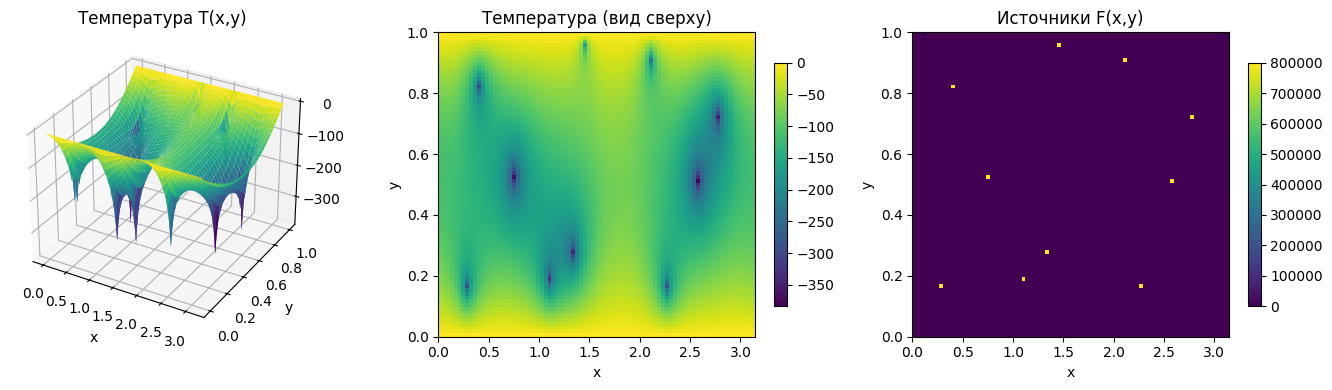

In [95]:
def main_b():
    Nx, Ny = 80, 80
    Xb, Yb, Tb, Fb = solve_plate_with_sources(
        Nx, Ny,
        num_sources=10,   # сколько источников
        intensity=800000.0,  # мощность каждого
        seed=111           # фиксируем для воспроизводимости
    )
    plot_plate_solution(Xb, Yb, Tb, Fb)

main_b()
